In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
import pennylane as qml
import pandas as pd
from matplotlib import pyplot as plt

from quantum_neural_network import qnode_entangling, qnode_strong_entangling
from stat_functions import quantitative_analysis, get_mean_left_right_error_interval, verify_distribution_wilcoxtest
from experiments_main import carregar_tabela
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

2023-11-20 14:07:46.248219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 14:07:46.376585: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 14:07:46.407154: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 14:07:47.002998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Plot Functions

In [2]:
def plot_history(history, n_layers):
    plt.figure(figsize=(14,5), dpi=320, facecolor='w', edgecolor='k')
    plt.title(f"Loss for depth {n_layers}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(history.history['loss'], label="Loss/Epoch")
    plt.plot(history.history['val_loss'], label="Val Loss/Epoch")
    plt.xticks(range(0, len(history.history['loss'])+1, 5))
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
def plot_prediction_versus_observed(n_layers, y_test, y_pred, mean_error_normal):
    for i in range(y_test.shape[1]):
        plt.figure(figsize=(20,5), dpi=320, facecolor='w', edgecolor='k')
        plt.title(f"Wind Speed Forecast for {i+1} hours ahead for {n_layers} layers")
        plt.xlabel("Samples")
        plt.ylabel("Wind Speed (m/s)")
        plt.plot(y_pred[:,i], label="Prediction", color='blue')
        plt.fill_between(range(y_pred.shape[0]), y_pred[:,i]-mean_error_normal[0,i], y_pred[:,i]+mean_error_normal[0,i], color='blue', alpha=0.05)
        plt.plot(y_test[:,i], label="Original", color='orange')
        plt.legend()
        plt.show()


## Importing Data

In [4]:
prev = 1
data_folder = "data"
city = "mucuri"
height = "150"

train_file = data_folder+"/"+city+"/"+height+"/"+"train"+height+"_"+city+".txt"
X_all,y_all = carregar_tabela(train_file, prev)

test_file = data_folder+"/"+city+"/"+height+"/"+"prev"+height+"_"+city+".txt"
X_test,y_test = carregar_tabela(test_file,prev)

n_features = X_all.shape[1]
n_instances = X_all.shape[0]
print(f"There are {n_features} features and {n_instances} instances in Train set")
print(f"There are {X_test.shape[1]} features and {X_test.shape[0]} instances in Test set")

There are 9 features and 548 instances in Train set
There are 9 features and 193 instances in Test set


In [5]:
X_all.head()

,0,1,2,3,4,5,6,7,8
0,30,11,2015,14,13.012139,75.105481,27.516129,72.930636,1020.422601
1,30,11,2015,15,12.726087,68.334332,27.238095,75.212121,1020.394348
2,30,11,2015,16,12.081111,64.457865,27.105263,75.741379,1020.508333
3,30,11,2015,17,11.647222,53.842100,26.305556,75.302632,1020.611000
4,30,11,2015,18,11.064444,53.945279,25.464286,76.592593,1020.866500


In [6]:
X_test.head()

,0,1,2,3,4,5,6,7,8
0,23,12,2015,12,12.242778,77.442821,21.516779,87.861111,1014.845833
1,23,12,2015,13,9.268333,73.171002,23.075269,73.338889,1014.793333
2,23,12,2015,14,8.734444,96.238878,22.545455,78.533333,1014.085333
3,23,12,2015,15,9.662222,110.156291,21.459770,83.722222,1013.541500
4,23,12,2015,16,8.620556,97.686662,22.133803,84.691275,1013.563333


## Scaling Data

In [7]:
scaler_x = MinMaxScaler(feature_range=(-1, 1))
#scaler_x = StandardScaler()
X_all_scaled = scaler_x.fit_transform(X_all)

X_test_scaled = scaler_x.transform(X_test)

In [8]:
print(X_all_scaled[0:5])

[[ 1.         -1.         -1.          0.2173913   0.90937393 -0.58515261
   0.44888689  0.02915543  0.92333644]
 [ 1.         -1.         -1.          0.30434783  0.86308842 -0.62328859
   0.39050308  0.117509    0.92268086]
 [ 1.         -1.         -1.          0.39130435  0.75872608 -0.64512135
   0.36260991  0.13800522  0.92532577]
 [ 1.         -1.         -1.          0.47826087  0.68851933 -0.70491071
   0.19468078  0.12101413  0.92770805]
 [ 1.         -1.         -1.          0.56521739  0.59422114 -0.70432959
   0.01802406  0.17096959  0.93363666]]


In [9]:
print(X_test_scaled[0:5])

[[ 0.51724138  1.         -1.          0.04347826  0.78488507 -0.57198841
  -0.81090577  0.607358    0.79393332]
 [ 0.51724138  1.         -1.          0.13043478  0.30359574 -0.59604785
  -0.48364124  0.04496558  0.79271511]
 [ 0.51724138  1.         -1.          0.2173913   0.21720817 -0.4661266
  -0.59489597  0.24612737  0.7762867 ]
 [ 0.51724138  1.         -1.          0.30434783  0.36733017 -0.38774195
  -0.82287686  0.44707401  0.76366762]
 [ 0.51724138  1.         -1.          0.39130435  0.19878002 -0.4579725
  -0.68133796  0.48460188  0.76417423]]


## Spliting Train, Validation and Test sets

In [10]:
train_ratio = 0.8
X_train, X_val, y_train, y_val = train_test_split(X_all_scaled, y_all, test_size=1 - train_ratio)

print(f"{X_train.shape=}")
print(f"{X_val.shape=}")
print(f"{X_test.shape=}")

X_train.shape=(438, 9)
X_val.shape=(110, 9)
X_test.shape=(193, 9)


## Quantum Neural Network

In [11]:
n_qubits = n_features
n_layers = 2
print(f"Circuit size: {n_qubits} qubits")

Circuit size: 9 qubits


In [12]:
weights = {"weights_1": (1,9,3)}
sampl_weights = np.random.uniform(low=0, high=np.pi, size=weights["weights_1"])
sampl_input = np.random.uniform(low=0, high=np.pi, size=(9,))
print(qml.draw(qnode_entangling, expansion_strategy="device")(sampl_input, sampl_weights))

0: ──H──RY(0.38)─╭●──Rot(1.85,0.58,1.19)──────────────────────┤  <Z>
1: ──H──RY(0.43)─╰X─╭●────────────────────Rot(2.98,1.76,0.27)─┤  <Z>
2: ──H──RY(0.06)─╭●─╰X────────────────────Rot(1.50,0.42,2.01)─┤  <Z>
3: ──H──RY(1.95)─╰X─╭●────────────────────Rot(1.97,2.51,0.60)─┤  <Z>
4: ──H──RY(2.40)─╭●─╰X────────────────────Rot(2.32,1.18,1.37)─┤  <Z>
5: ──H──RY(2.93)─╰X─╭●────────────────────Rot(1.17,1.81,1.25)─┤  <Z>
6: ──H──RY(0.55)─╭●─╰X────────────────────Rot(3.14,2.83,2.15)─┤  <Z>
7: ──H──RY(0.07)─╰X─╭●────────────────────Rot(1.84,2.34,1.46)─┤  <Z>
8: ──H──RY(2.31)────╰X────────────────────Rot(1.48,1.13,1.79)─┤  <Z>


In [13]:
def create_quantum_model(n_layers, n_qubits, strong_entangling=False):
    print(f"Training with depth {n_layers}")
    weight_shapes = {"weights": (n_layers,n_qubits,3)}

    if strong_entangling:
        q_layer = qml.qnn.KerasLayer(qnode_strong_entangling, weight_shapes, output_dim=n_qubits)
    else:
        q_layer = qml.qnn.KerasLayer(qnode_entangling, weight_shapes, output_dim=n_qubits)
    activation=tf.keras.layers.Activation(tf.keras.activations.relu)
    output_layer = tf.keras.layers.Dense(prev,kernel_initializer='normal')

    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.1)

    model = tf.keras.models.Sequential([q_layer, activation, output_layer])
    model.compile(loss=['mse'], optimizer=optimizer, metrics=['mae'])

    return model


In [14]:
model = create_quantum_model(n_layers, n_qubits)
input_shape = (n_qubits,)
model.build(input_shape)
print(model.summary())

Training with depth 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (9, 9)                    54        
                                                                 
 activation (Activation)     (9, 9)                    0         
                                                                 
 dense (Dense)               (9, 1)                    10        
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
None


2023-11-20 14:07:51.201405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 14:07:53.333818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30974 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:30:00.0, compute capability: 7.0
2023-11-20 14:07:53.335045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30974 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:6d:00.0, compute capability: 7.0
2023-11-20 14:07:53.335583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/r

In [15]:
es=EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
re=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0, mode='min', min_lr=0.00001)
history_model = model.fit(X_train, y_train
                        , epochs=50, batch_size=32
                        , verbose=1
                        , validation_data=(X_val, y_val))

Epoch 1/50
14/14 [==============================] - 7s 422ms/step - loss: 41.6242 - mae: 5.7289 - val_loss: 10.0766 - val_mae: 2.6496
Epoch 2/50
14/14 [==============================] - 6s 417ms/step - loss: 6.7187 - mae: 2.1346 - val_loss: 5.1343 - val_mae: 1.8062
Epoch 3/50
14/14 [==============================] - 6s 416ms/step - loss: 5.1404 - mae: 1.8456 - val_loss: 4.2525 - val_mae: 1.6413
Epoch 4/50
14/14 [==============================] - 6s 417ms/step - loss: 4.2451 - mae: 1.6512 - val_loss: 3.4789 - val_mae: 1.4574
Epoch 5/50
14/14 [==============================] - 6s 434ms/step - loss: 3.4698 - mae: 1.4991 - val_loss: 3.1753 - val_mae: 1.3729
Epoch 6/50
14/14 [==============================] - 6s 414ms/step - loss: 2.9609 - mae: 1.3817 - val_loss: 2.6461 - val_mae: 1.2576
Epoch 7/50
14/14 [==============================] - 6s 419ms/step - loss: 2.6070 - mae: 1.2894 - val_loss: 2.4347 - val_mae: 1.2017
Epoch 8/50
14/14 [==============================] - 6s 413ms/step - loss: 

## Plotting Loss

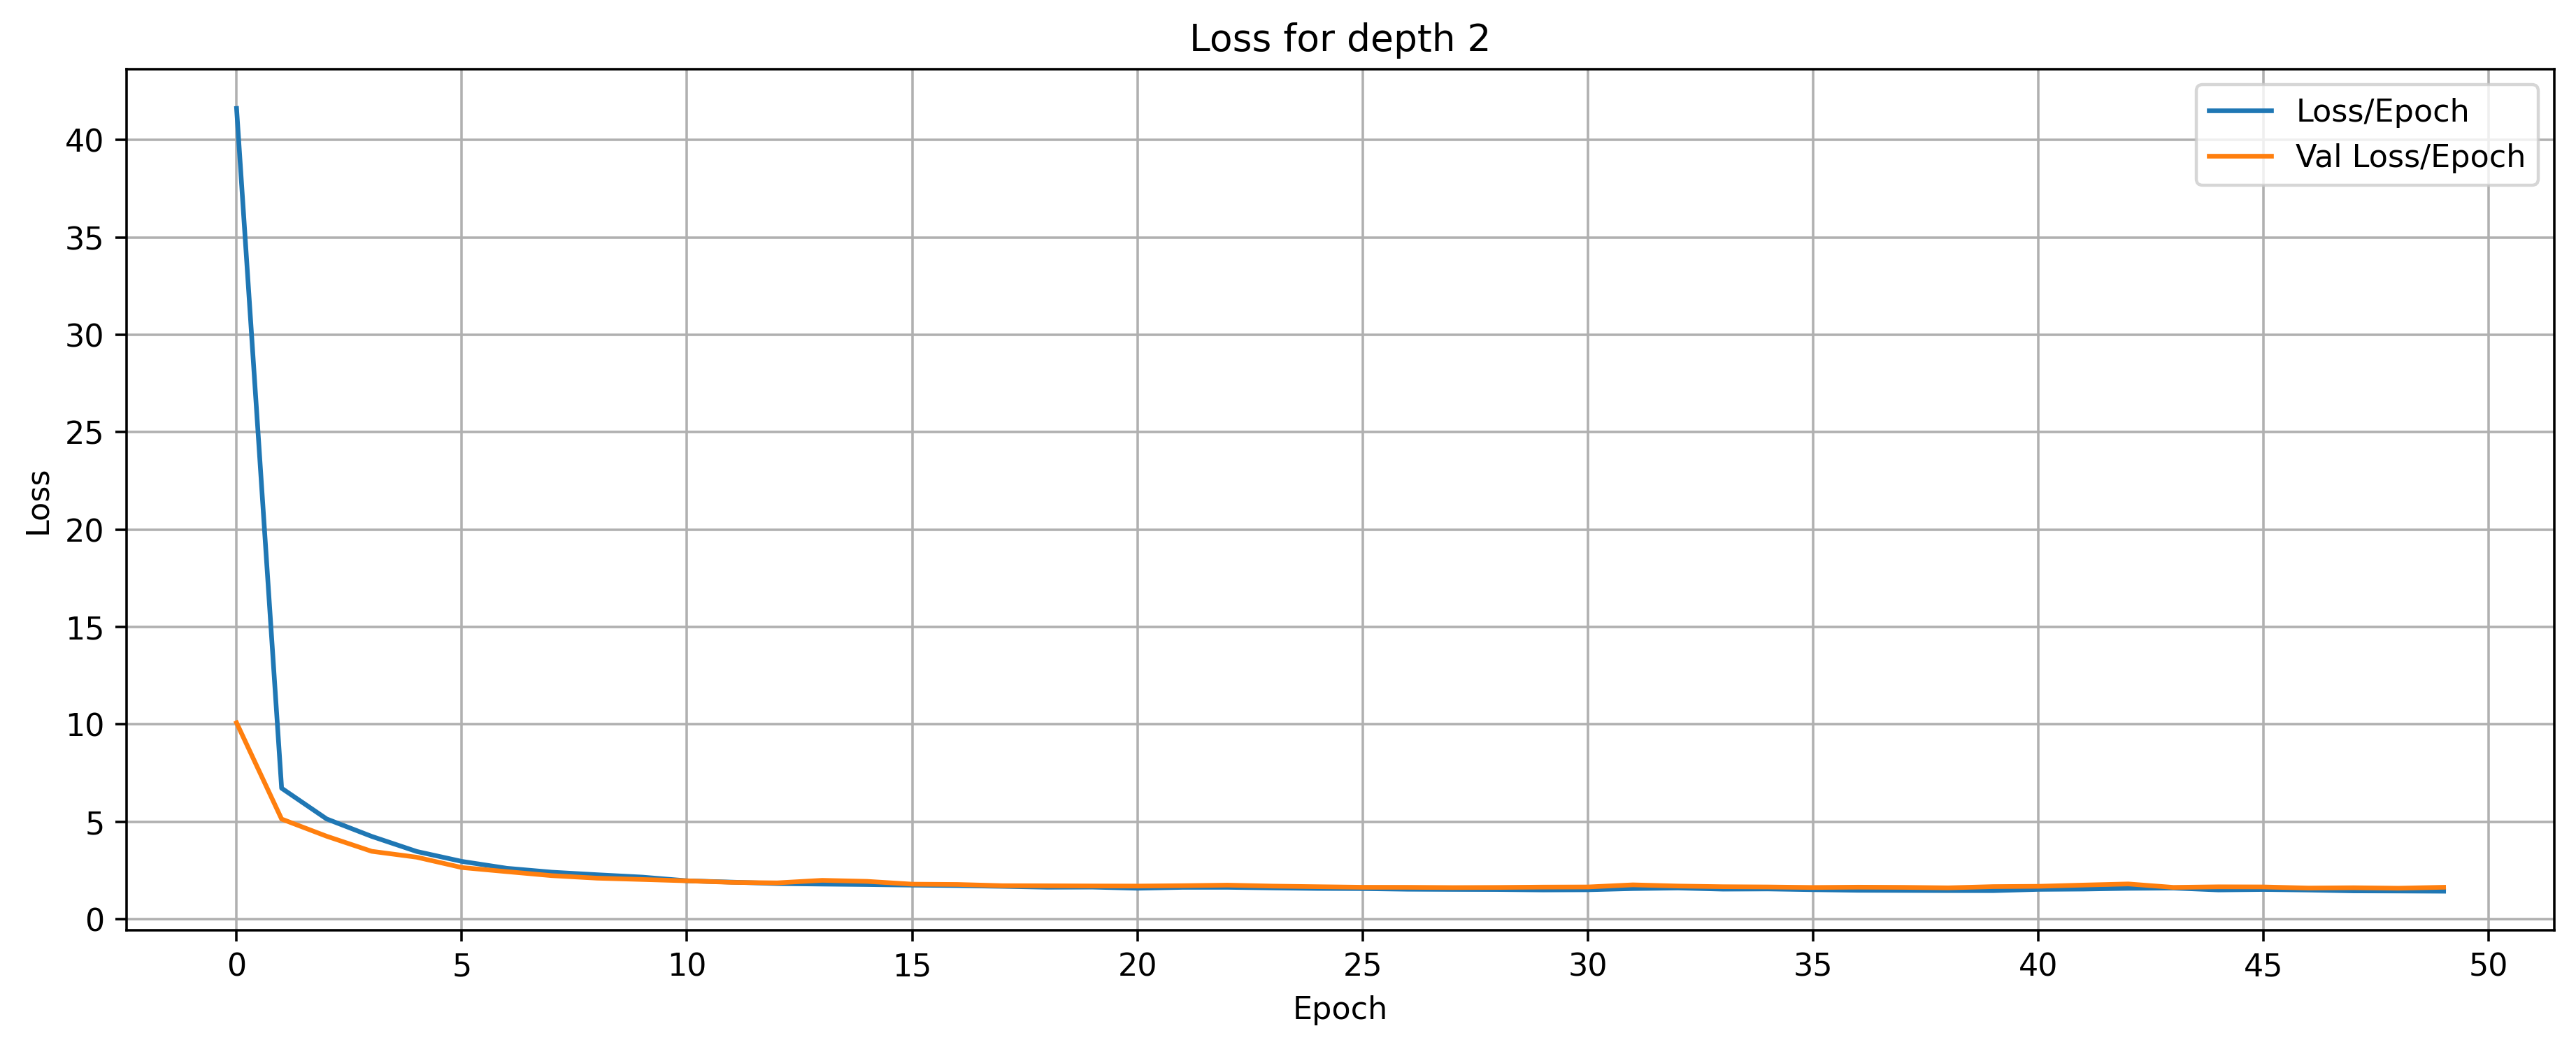

In [16]:
plot_history(history_model, n_layers)

## Prediction

4/4 [==============================] - 1s 177ms/step


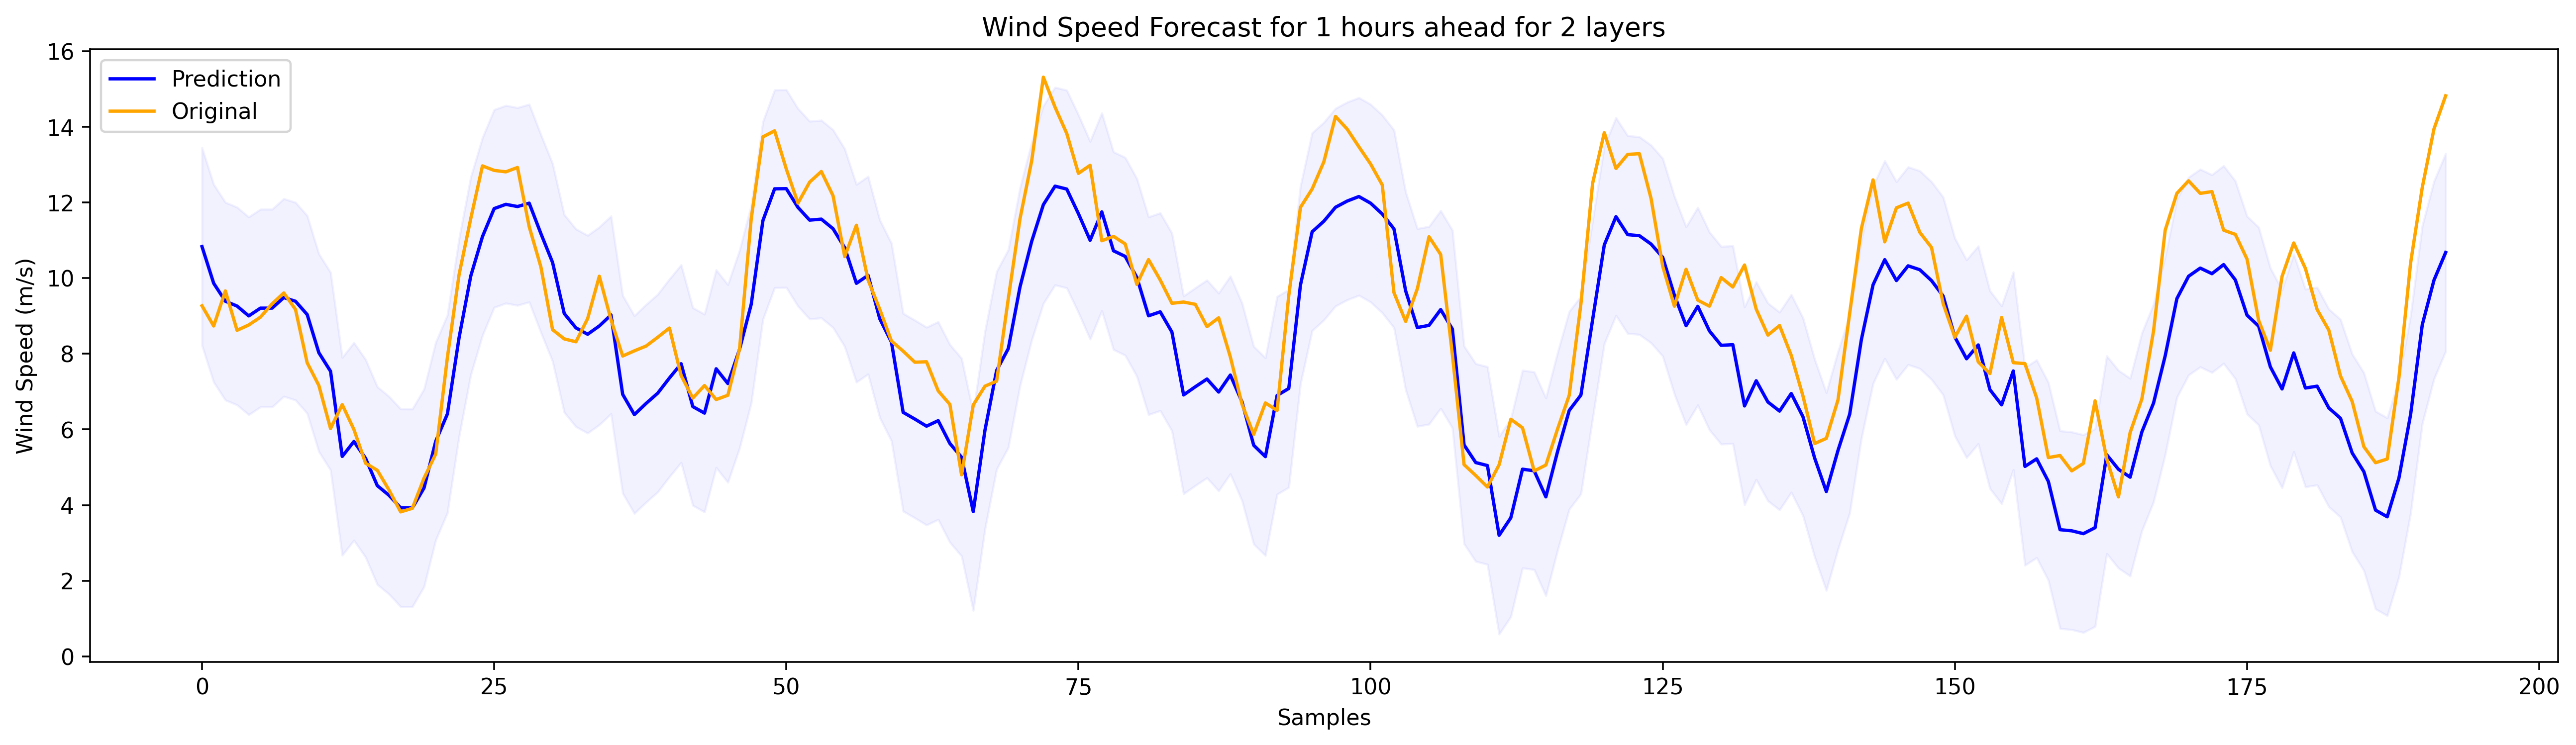

In [17]:
y_pred = model.predict(X_test_scaled,verbose=1)
mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal = get_mean_left_right_error_interval(model, scaler_x, X_val, y_val, y_test, y_pred)
plot_prediction_versus_observed(n_layers, y_test, y_pred, mean_error_normal)


## Statistical Analysis

In [18]:
all_analysis = quantitative_analysis(y_test, [y_pred])
all_analysis

MAE: 1.2950197773359489
MSE: 2.5726286733163746
NMSE: 0.35179951655422115
RMSE: 1.6039416053324307
NRMSE: 0.5931268975136949
R: 0.8940270785473337
R²: 0.6463681942970589
Fator de 2: 1.0


,MAE,MSE,NMSE,RMSE,NRMSE,R,R²,Fator de 2
Index,,,,,,,,
1 depth,1.29502,2.572629,0.3518,1.603942,0.593127,0.894027,0.646368,1.0


In [19]:
verify_distribution_wilcoxtest(y_test[:,0],y_pred[:,0], 0.05)

Statistics=2103.000, p=0.000
Different distribution (reject H0)


(2103.0, 9.612326773236227e-21)

## Creating model with strong entangling and searching for statistical difference

In [20]:
weights = {"weights_1": (1,9,3)}
sampl_weights = np.random.uniform(low=0, high=np.pi, size=weights["weights_1"])
sampl_input = np.random.uniform(low=0, high=np.pi, size=(9,))
print(qml.draw(qnode_strong_entangling, expansion_strategy="device")(sampl_input, sampl_weights))

0: ──H──RY(1.88)─╭●──────────────────────╭X──Rot(1.29,2.50,0.39)─┤  <Z>
1: ──H──RY(2.84)─╰X─╭●───────────────────│───Rot(2.55,1.65,2.80)─┤  <Z>
2: ──H──RY(1.55)────╰X─╭●────────────────│───Rot(0.90,0.75,2.23)─┤  <Z>
3: ──H──RY(3.07)───────╰X─╭●─────────────│───Rot(1.27,1.59,1.06)─┤  <Z>
4: ──H──RY(0.91)──────────╰X─╭●──────────│───Rot(2.30,0.61,0.63)─┤  <Z>
5: ──H──RY(0.89)─────────────╰X─╭●───────│───Rot(0.52,1.26,1.42)─┤  <Z>
6: ──H──RY(2.21)────────────────╰X─╭●────│───Rot(2.62,0.57,0.02)─┤  <Z>
7: ──H──RY(2.84)───────────────────╰X─╭●─│───Rot(2.02,1.57,3.00)─┤  <Z>
8: ──H──RY(0.79)──────────────────────╰X─╰●──Rot(0.29,2.21,0.81)─┤  <Z>


In [21]:
strong_model = create_quantum_model(n_layers, n_qubits, strong_entangling=True)
input_shape = (n_qubits,)
strong_model.build(input_shape)
strong_model.summary()

Training with depth 2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (9, 9)                    54        
                                                                 
 activation_1 (Activation)   (9, 9)                    0         
                                                                 
 dense_1 (Dense)             (9, 1)                    10        
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [22]:
strong_history_model = strong_model.fit(X_train, y_train
                        , epochs=50, batch_size=32
                        , verbose=1
                        , validation_data=(X_val, y_val))

Epoch 1/50
14/14 [==============================] - 6s 427ms/step - loss: 49.0024 - mae: 6.3638 - val_loss: 17.3022 - val_mae: 3.5729
Epoch 2/50
14/14 [==============================] - 6s 423ms/step - loss: 8.7477 - mae: 2.3669 - val_loss: 4.8177 - val_mae: 1.7381
Epoch 3/50
14/14 [==============================] - 6s 422ms/step - loss: 4.6663 - mae: 1.7326 - val_loss: 3.5651 - val_mae: 1.5218
Epoch 4/50
14/14 [==============================] - 6s 432ms/step - loss: 3.7494 - mae: 1.5341 - val_loss: 2.7281 - val_mae: 1.3418
Epoch 5/50
14/14 [==============================] - 6s 426ms/step - loss: 3.0988 - mae: 1.3886 - val_loss: 2.2164 - val_mae: 1.2114
Epoch 6/50
14/14 [==============================] - 6s 431ms/step - loss: 2.4779 - mae: 1.2455 - val_loss: 1.9147 - val_mae: 1.1061
Epoch 7/50
14/14 [==============================] - 6s 430ms/step - loss: 2.0631 - mae: 1.1258 - val_loss: 1.8349 - val_mae: 1.0796
Epoch 8/50
14/14 [==============================] - 6s 428ms/step - loss: 

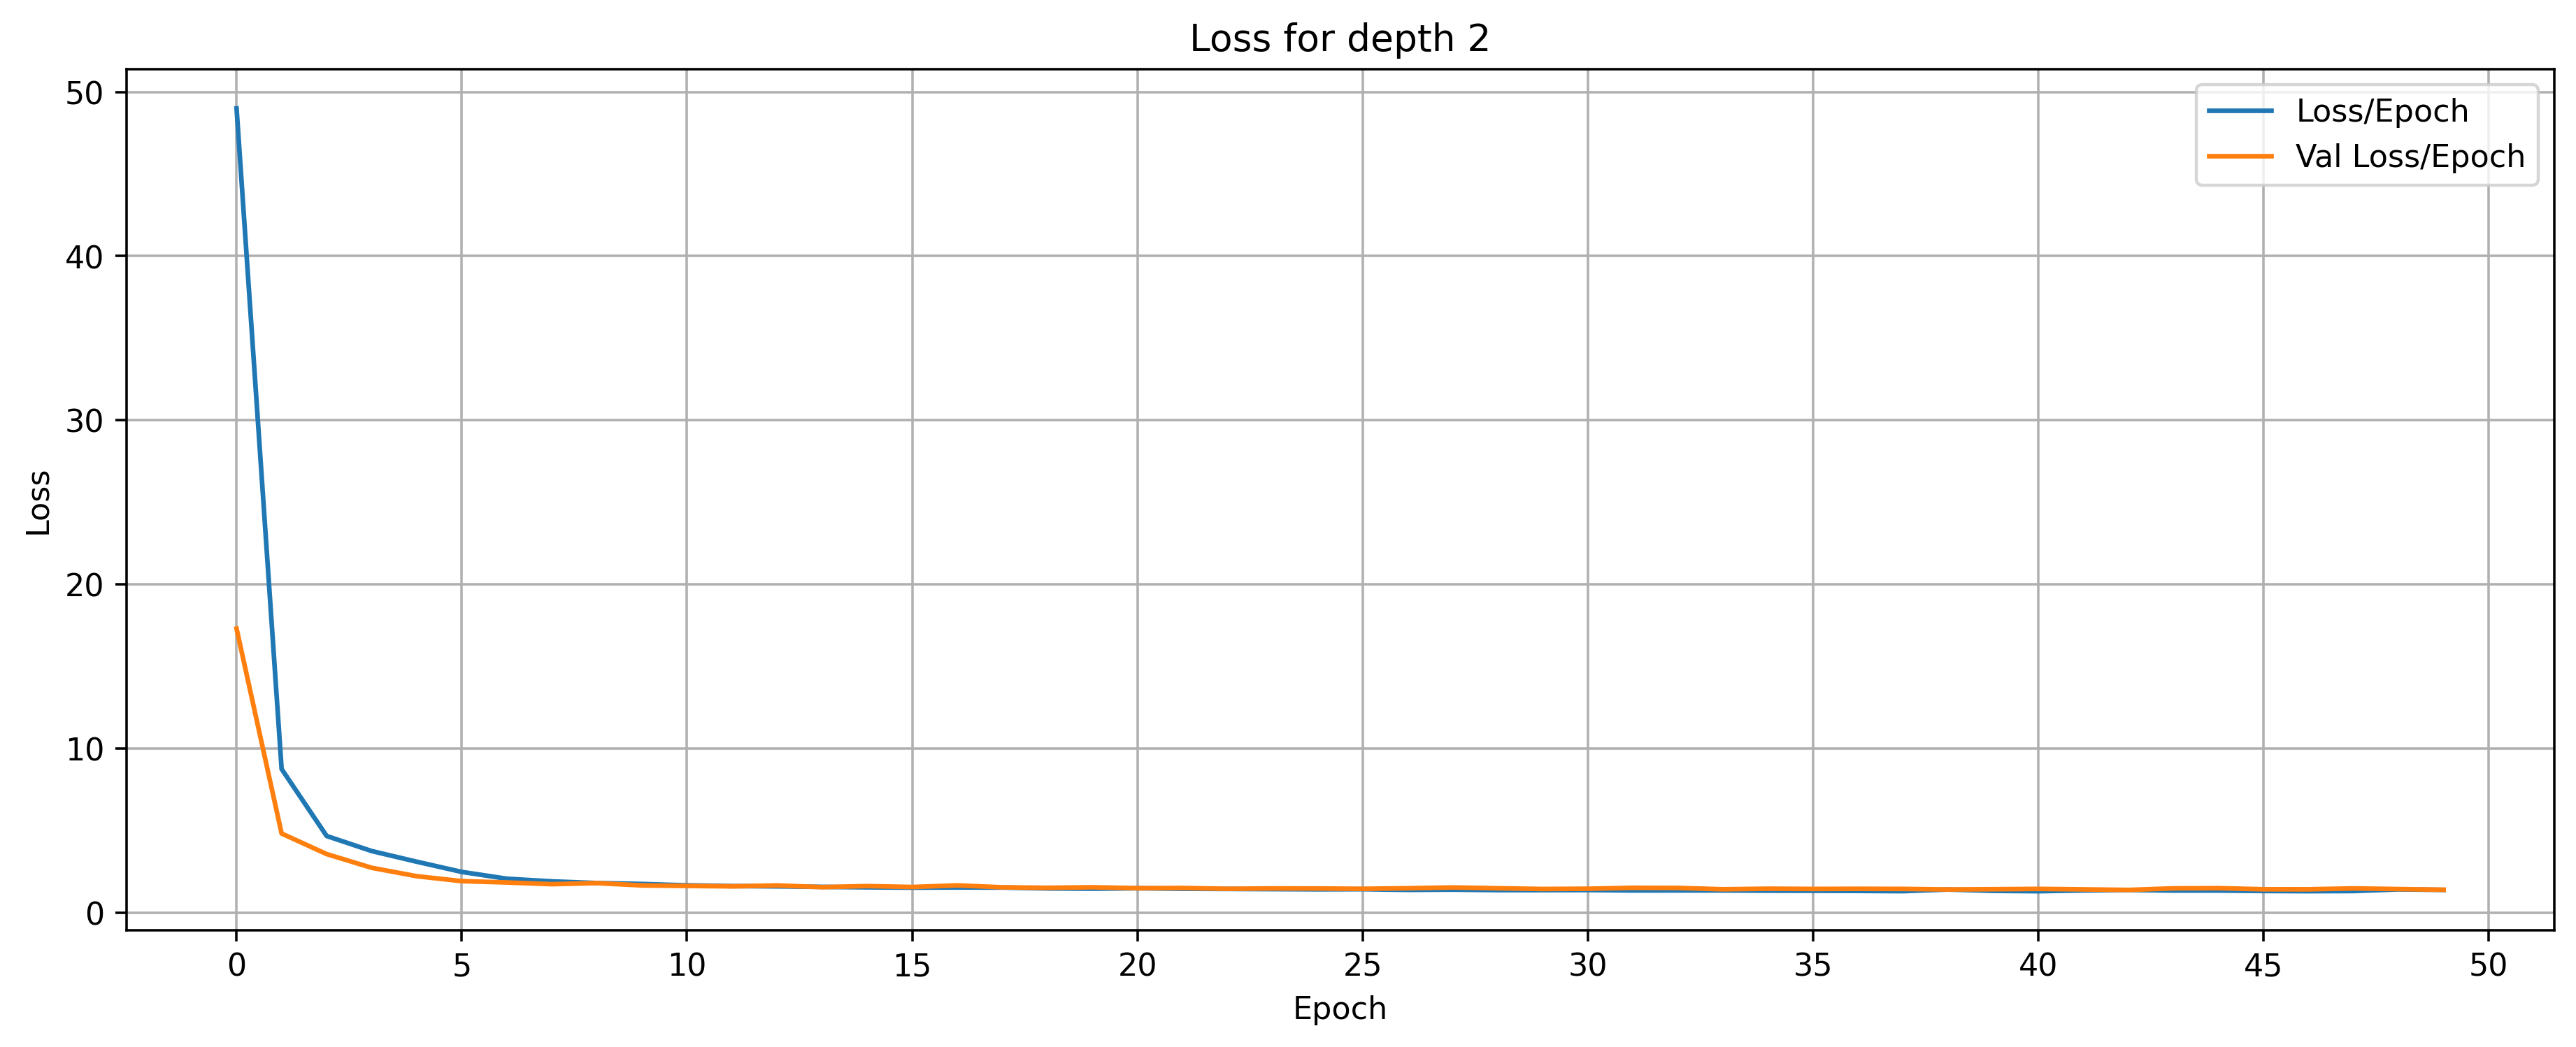

In [23]:
plot_history(strong_history_model, n_layers)

4/4 [==============================] - 1s 189ms/step


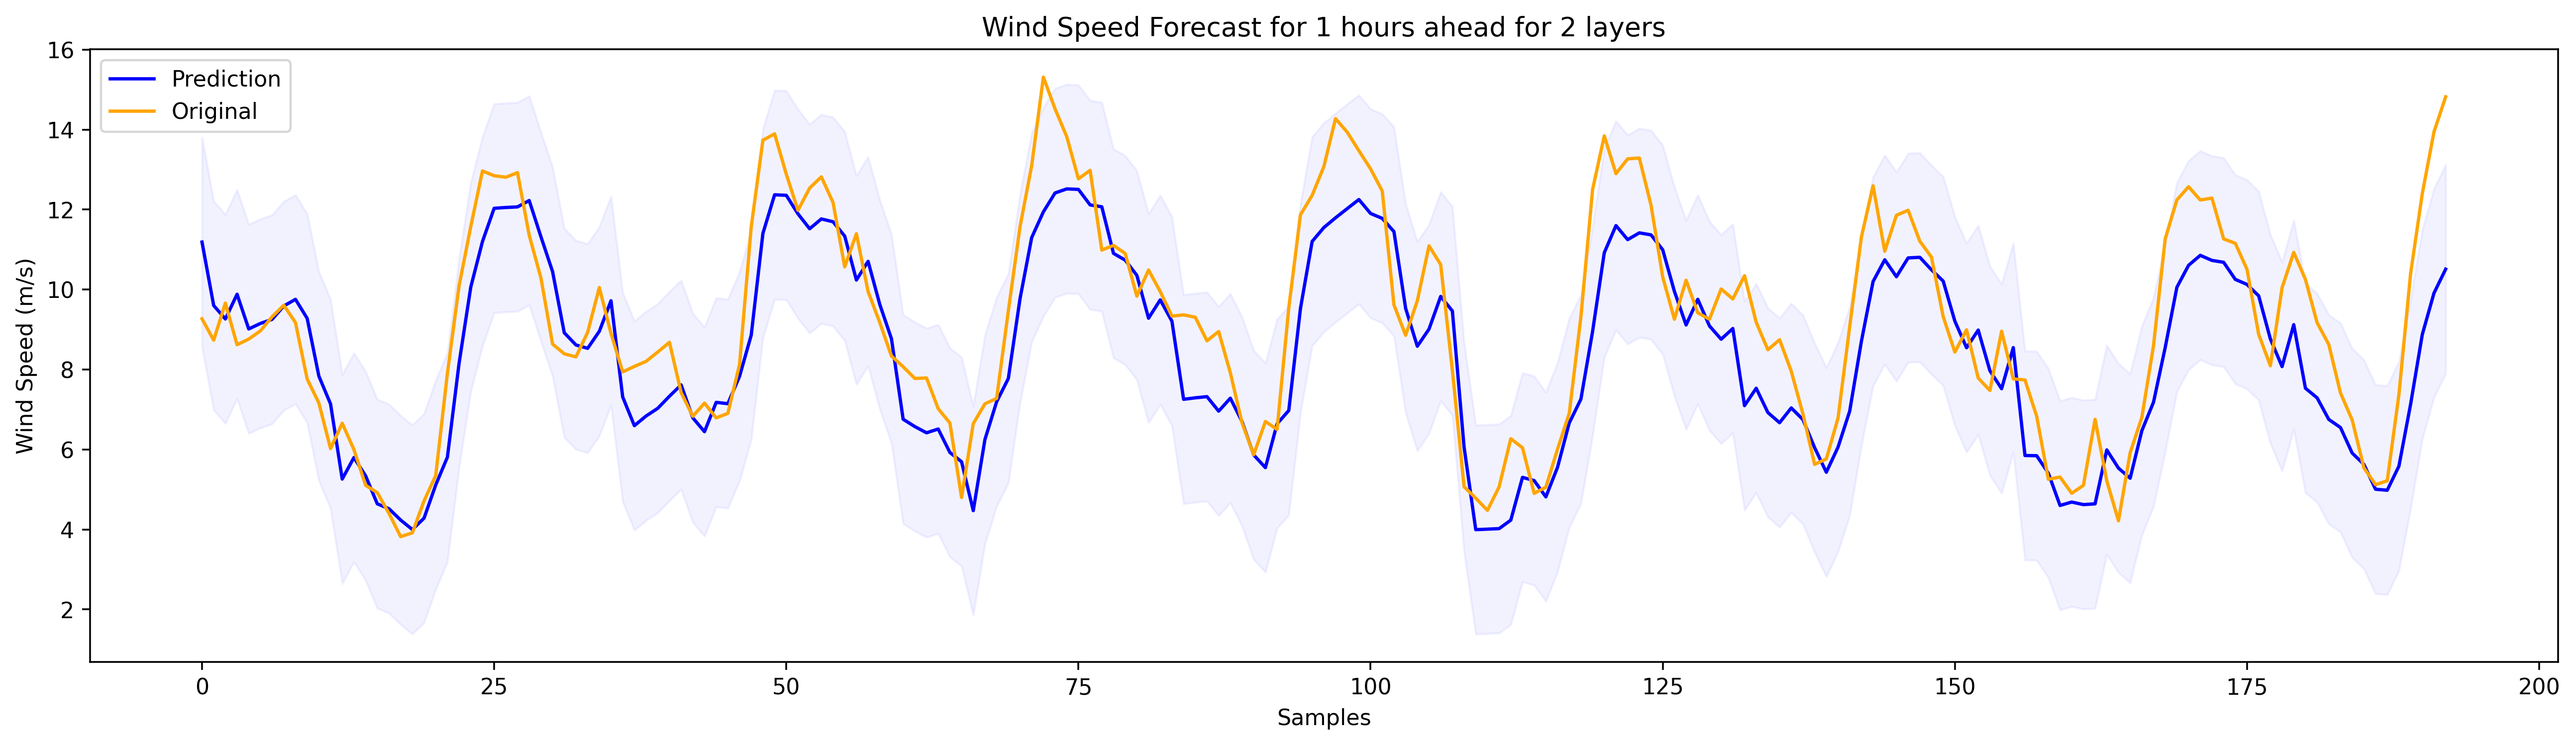

In [24]:
strong_y_pred = strong_model.predict(X_test_scaled,verbose=1)
mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal = get_mean_left_right_error_interval(model, scaler_x, X_val, y_val, y_test, strong_y_pred)
plot_prediction_versus_observed(n_layers, y_test, strong_y_pred, mean_error_normal)


In [25]:
strong_analysis = quantitative_analysis(y_test, [strong_y_pred])
strong_analysis

MAE: 1.124246969497541
MSE: 1.9928378142978298
NMSE: 0.2725147966018687
RMSE: 1.4116790762414204
NRMSE: 0.5220294978273438
R: 0.8965171878018375
R²: 0.7260658554991632
Fator de 2: 1.0


,MAE,MSE,NMSE,RMSE,NRMSE,R,R²,Fator de 2
Index,,,,,,,,
1 depth,1.124247,1.992838,0.272515,1.411679,0.522029,0.896517,0.726066,1.0


In [26]:
verify_distribution_wilcoxtest(y_test[:,0],strong_y_pred[:,0], 0.05)

Statistics=3605.000, p=0.000
Different distribution (reject H0)


(3605.0, 1.2900038856847085e-13)

## Creating deeper model and searching for statistical difference

In [27]:
n_layers = 6
model2 = create_quantum_model(n_layers, n_qubits, strong_entangling=False)
input_shape = (n_qubits,)
model2.build(input_shape)
model2.summary()

Training with depth 6
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (9, 9)                    162       
                                                                 
 activation_2 (Activation)   (9, 9)                    0         
                                                                 
 dense_2 (Dense)             (9, 1)                    10        
                                                                 
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________


In [28]:
history_model2 = model2.fit(X_train, y_train
                        , epochs=50, batch_size=32
                        , verbose=1
                        , validation_data=(X_val, y_val))

Epoch 1/50
14/14 [==============================] - 15s 1s/step - loss: 47.3382 - mae: 6.2044 - val_loss: 14.8896 - val_mae: 3.2808
Epoch 2/50
14/14 [==============================] - 15s 1s/step - loss: 7.2396 - mae: 2.1350 - val_loss: 4.3241 - val_mae: 1.6003
Epoch 3/50
14/14 [==============================] - 15s 1s/step - loss: 4.1200 - mae: 1.6040 - val_loss: 3.2663 - val_mae: 1.3816
Epoch 4/50
14/14 [==============================] - 15s 1s/step - loss: 3.0873 - mae: 1.3632 - val_loss: 2.8731 - val_mae: 1.2596
Epoch 5/50
14/14 [==============================] - 15s 1s/step - loss: 2.5594 - mae: 1.2099 - val_loss: 2.6146 - val_mae: 1.2044
Epoch 6/50
14/14 [==============================] - 15s 1s/step - loss: 2.2481 - mae: 1.1195 - val_loss: 2.4826 - val_mae: 1.1812
Epoch 7/50
14/14 [==============================] - 15s 1s/step - loss: 2.1070 - mae: 1.0932 - val_loss: 2.3881 - val_mae: 1.1808
Epoch 8/50
14/14 [==============================] - 15s 1s/step - loss: 1.9358 - mae: 1.

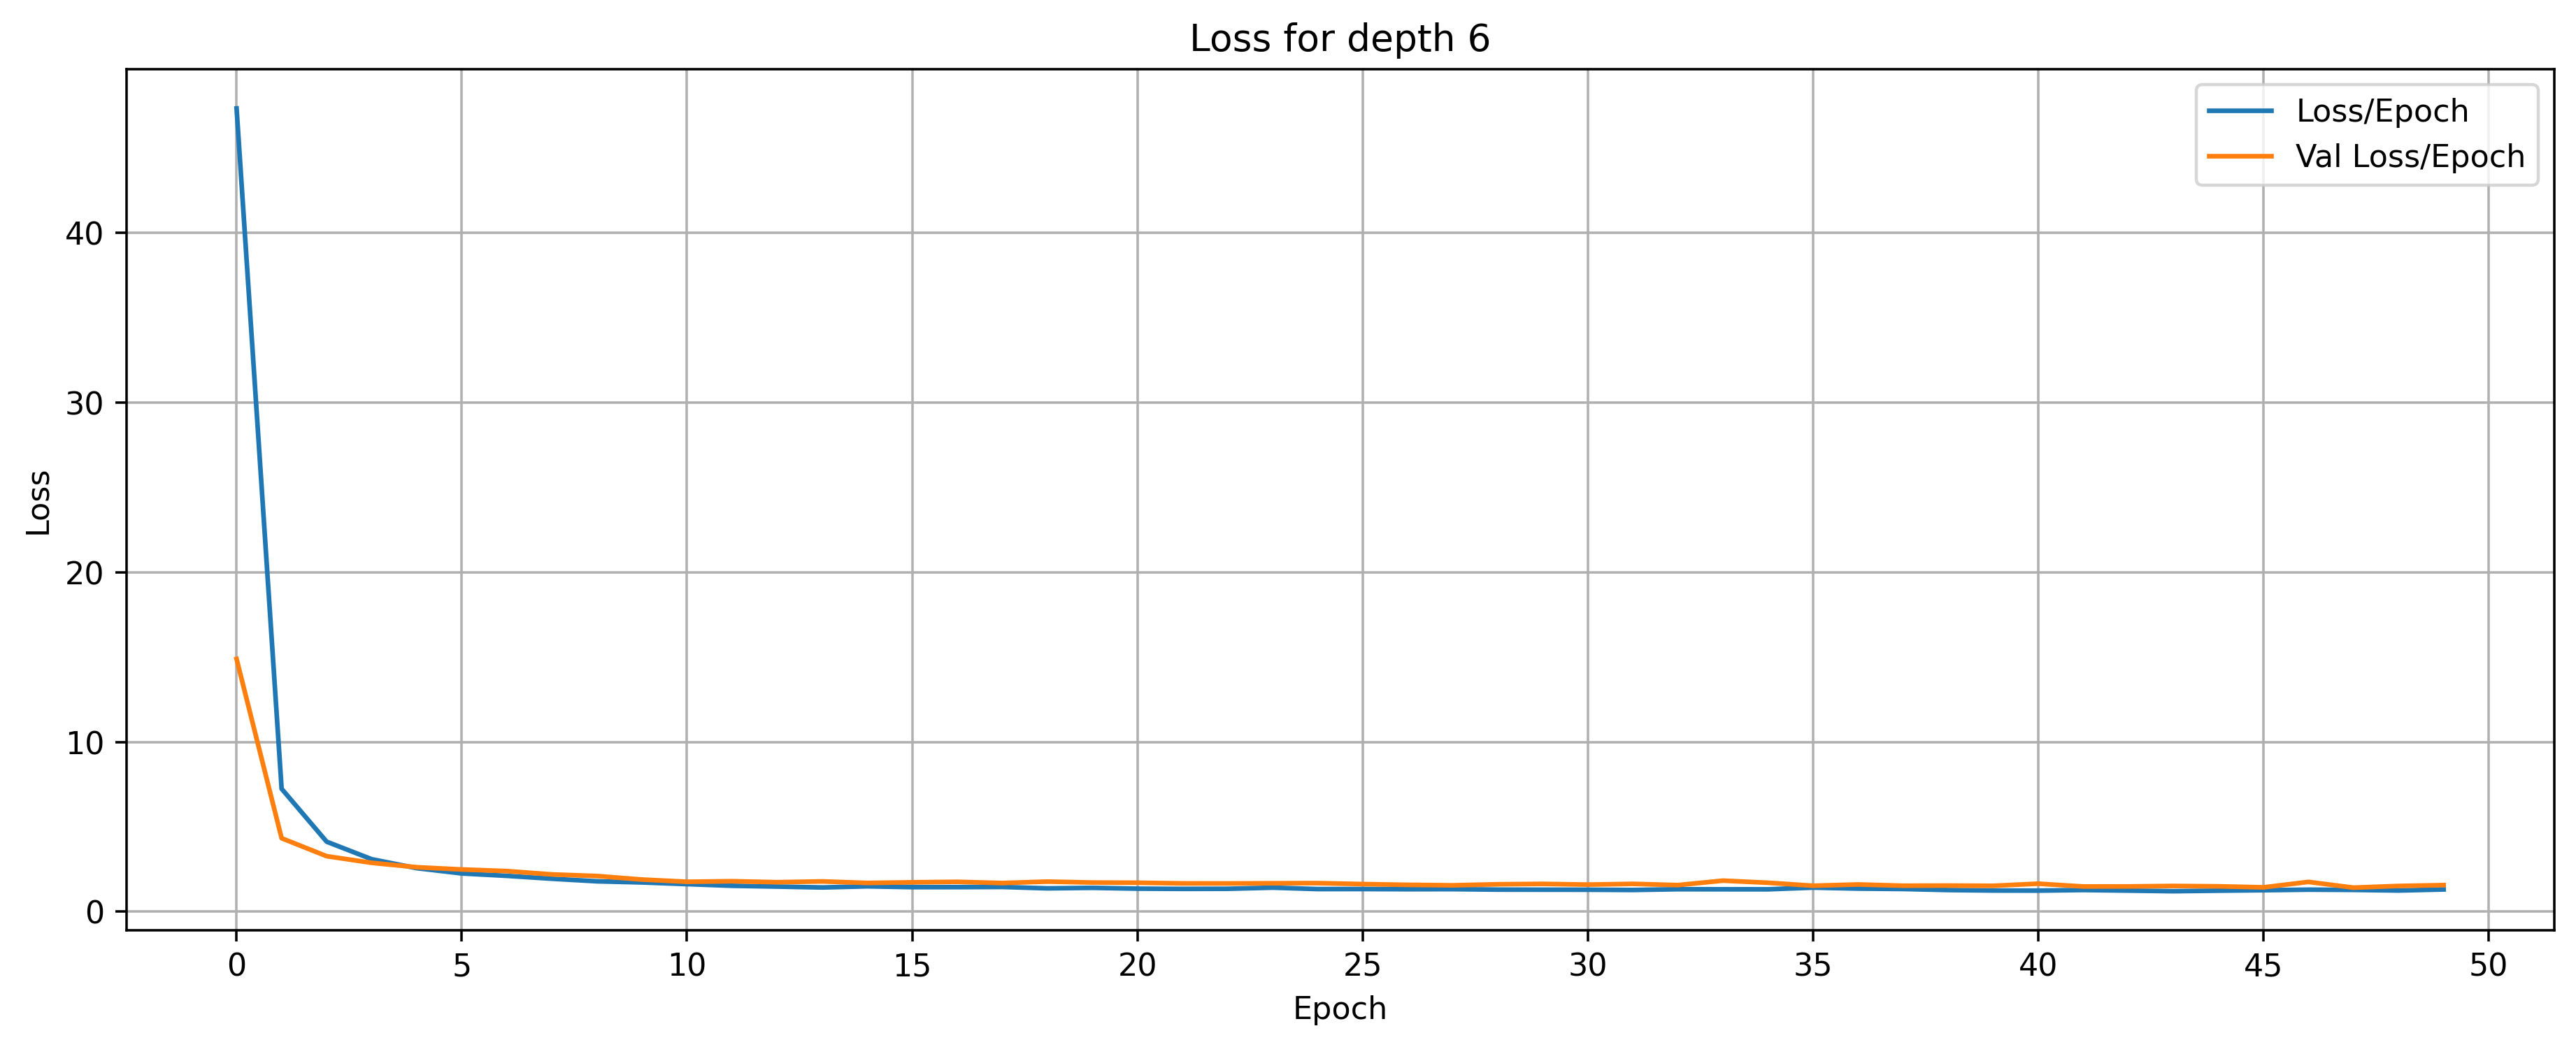

In [29]:
plot_history(history_model2, n_layers)

4/4 [==============================] - 1s 186ms/step


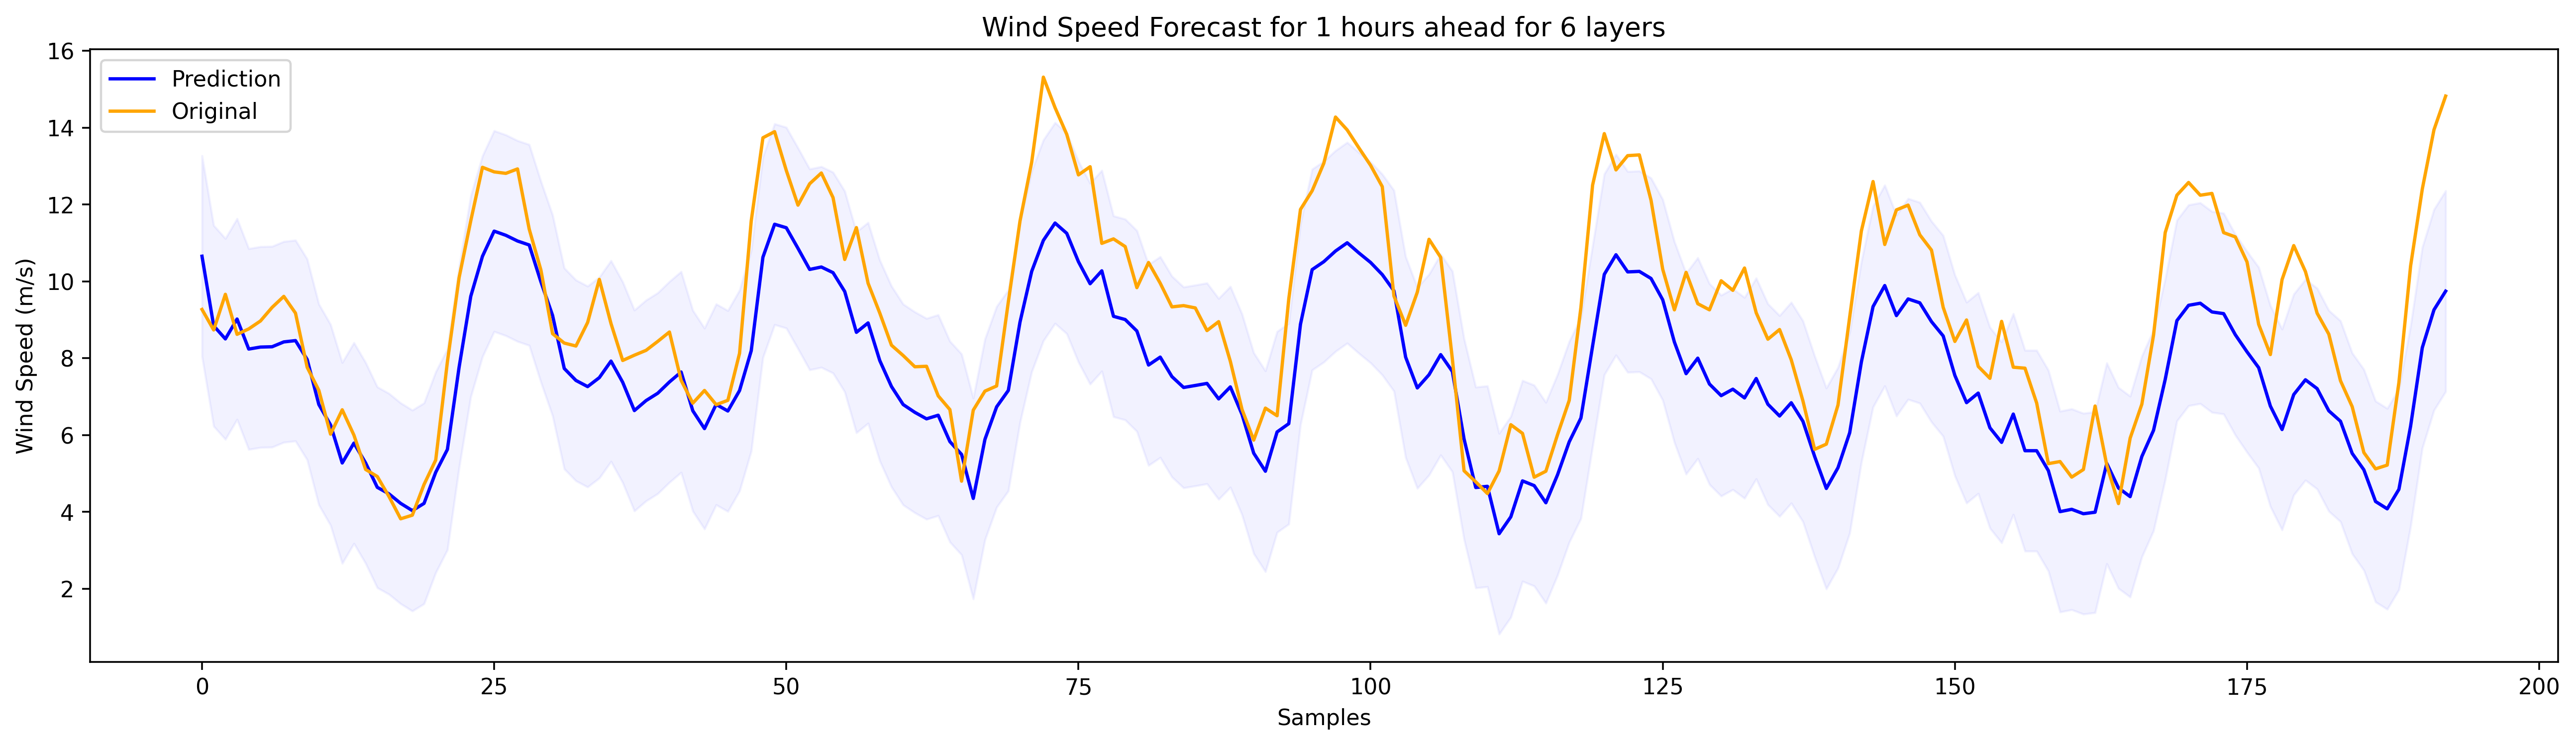

In [30]:
y_pred2 = model2.predict(X_test_scaled,verbose=1)
mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal = get_mean_left_right_error_interval(model, scaler_x, X_val, y_val, y_test, y_pred2)
plot_prediction_versus_observed(n_layers, y_test, y_pred2, mean_error_normal)


In [31]:
all_analysis2 = quantitative_analysis(y_test, [y_pred2])
all_analysis2

MAE: 1.6877418568081761
MSE: 4.079173377900484
NMSE: 0.5578151394994426
RMSE: 2.0196963578470117
NRMSE: 0.7468702293567756
R: 0.9086460841167238
R²: 0.4392795733156645
Fator de 2: 1.0


,MAE,MSE,NMSE,RMSE,NRMSE,R,R²,Fator de 2
Index,,,,,,,,
1 depth,1.687742,4.079173,0.557815,2.019696,0.74687,0.908646,0.43928,1.0


In [32]:
verify_distribution_wilcoxtest(y_test[:,0],y_pred2[:,0], 0.05)

Statistics=391.000, p=0.000
Different distribution (reject H0)


(391.0, 7.958521216619877e-31)